В библиотеке Scikit-Learn есть датасет картинок с рукописными цифрами, посмотрим на эти данные:

In [1]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.images.shape

(1797, 8, 8)

Данные изображений представляют собой трехмерный массив: 1797 выборок,
каждая состоит из сетки пикселов размером 8 × 8. Визуализируем первую их сотню

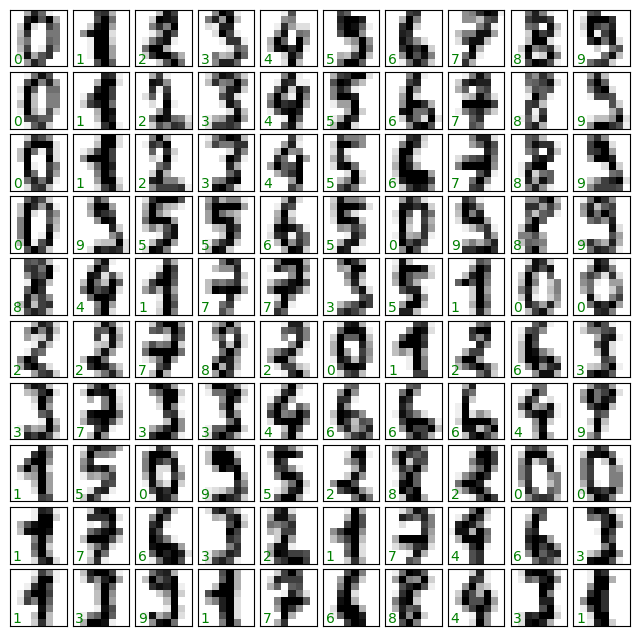

In [2]:
import matplotlib.pyplot as plt
#Подготавливаем к отображению
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                        subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))
# и выводим 10 строк по 10 картинок цифр
for i, ax in enumerate(axes.flat):
  ax.imshow(digits.images[i], cmap='binary',interpolation='nearest')
  #Зеленым цветом в углу подписывем картинки соответствующей цифрой
  ax.text(0.05, 0.05, str(digits.target[i]),transform=ax.transAxes, color='green')

Отложим для последующей проверки работы модели последние 10 цифр из датасета, признаки-предикторы поместим в X_last:

In [3]:
n = digits.images.shape[0]
m = n-10
digit_s = digits.images[m:]
X_last = digits.data[m:,:]
#X_last.shape



а сами значения цифр - в y_last

In [4]:
y_last = digits.target[m:]
print('Цифры = ', y_last)

Цифры =  [5 4 8 8 4 9 0 8 9 8]


Отобразим эти картинки с цифрами

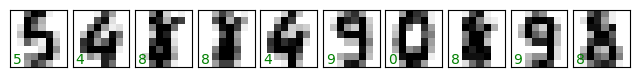

In [5]:
fig, axes = plt.subplots(1, 10, figsize=(8, 8),
                        subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))
# и выводим строку из 10 картинок цифр
for i, ax in enumerate(axes.flat):
  ax.imshow(digit_s[i], cmap='binary',interpolation='nearest')
  #Зеленым цветом в углу подписывем картинки соответствующей цифрой
  ax.text(0.05, 0.05, str(y_last[i]),transform=ax.transAxes, color='green')

Для работы с этими данными в библиотеке Scikit-Learn нам нужно получить их
двумерное представление [n_samples, n_features]. Для этого мы будем трактовать каждый пиксел в изображении как признак, то есть «расплющим» массивы
пикселов так, чтобы каждую цифру представлял не квадратный массив  8х8 пикселов, а одномерный массив длиной 64 элемента. Кроме этого, нам понадобится целевой массив, задающий для каждой цифры предопределенную метку (правильный ответ). Эти два параметра встроены в набор данных цифр
в виде атрибутов data и target, соответственно:

In [6]:
X = digits.data[:m,:]
X.shape


(1787, 64)

In [7]:
y = digits.target[:m]
y.shape

(1787,)

Итого получаем 1787 выборок и 64 признака. Преобразуем
данные в двумерный вид, чтобы появилась возможность их визуализации:

In [8]:
 from sklearn.manifold import Isomap
 iso = Isomap(n_components=2)
 iso.fit(digits.data[:m,:])
 data_projected = iso.transform(digits.data[:m,:])
 data_projected.shape

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_isomap.py:352: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


(1787, 2)

Теперь наши данные стали двумерными. Построим график этих данных, чтобы
увидеть, можно ли что-то понять из их структуры

<ipython-input-9-6e8e240419b8>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10))


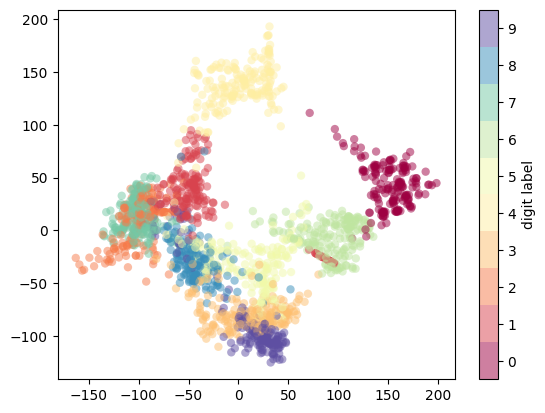

In [9]:
plt.scatter(data_projected[:, 0], data_projected[:, 1], c=digits.target[:m], edgecolor='none',
            alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 10))
plt.colorbar(label='digit label', ticks=range(10))
plt.clim(-0.5, 9.5);

В целом различные группы достаточно хорошо разнесены в параметрическом
пространстве. Это значит, что даже довольно простой алгоритм классификации
с учителем (когда известны правильные ответы) должен работать на них достаточно хорошо.

Применим алгоритм классификации к нашим цифрам. Разобьем данные на обучающую и тестовую выборки, после чего обучим на первой из них модель XGBoost:

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

from xgboost import XGBClassifier
model = XGBClassifier(n_estimators = 100, max_depth = 5, learning_rate = 0.07)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Оценка качества предсказания модели с помощью кросстаблицы

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
pd.crosstab(y_test, y_pred)

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,33,0,0,0,0,0,0,0,1,0
1,0,36,1,1,0,0,0,0,0,1
2,0,0,43,2,0,0,0,0,0,0
3,0,1,0,30,0,0,0,0,1,2
4,2,1,0,0,28,0,0,0,0,0
5,0,0,0,0,0,34,1,0,0,1
6,0,1,0,0,0,0,34,0,0,0
7,0,0,0,0,0,0,0,33,0,0
8,0,1,0,1,0,0,0,0,34,1


То же с цветом

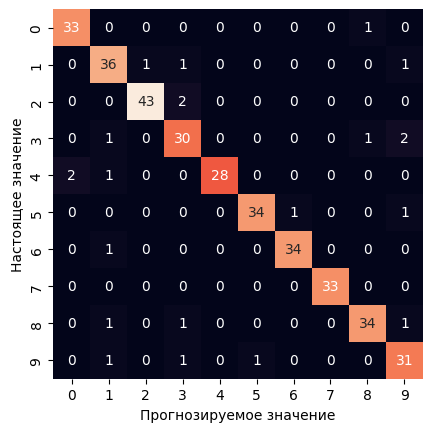

In [12]:
 from sklearn.metrics import confusion_matrix
 mat = confusion_matrix(y_test, y_pred)
 sns.heatmap(data = mat, square=True, annot=True, cbar=False,  linecolor='white')
 plt.xlabel('Прогнозируемое значение')
 plt.ylabel('Настоящее значение');

Оценка качества предсказания модели с помощью метрик

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

print(model.score(X_test,y_test))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96        34
           1       0.88      0.92      0.90        39
           2       0.98      0.96      0.97        45
           3       0.86      0.88      0.87        34
           4       1.00      0.90      0.95        31
           5       0.97      0.94      0.96        36
           6       0.97      0.97      0.97        35
           7       1.00      1.00      1.00        33
           8       0.94      0.92      0.93        37
           9       0.86      0.91      0.89        34

    accuracy                           0.94       358
   macro avg       0.94      0.94      0.94       358
weighted avg       0.94      0.94      0.94       358

0.9385474860335196


Спрогнозируем для последних 10 цифр (отоложенных вначале) их значения и сравним с реальностью

In [14]:
y_pred_last = model.predict(X_last)

print('Цифры фактические = ',*y_last,"\n Цифры по прогнозу =", *y_pred_last)

Цифры фактические =  5 4 8 8 4 9 0 8 9 8 
 Цифры по прогнозу = 5 4 8 1 4 9 0 8 9 8
